In [2]:
# import sys
# sys.path.append('../selectdata/search_from_es')

In [ ]:
print(sys.path)

In [2]:
from elasticsearch import Elasticsearch
from get_data import twitter, epa, bom, health
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [3]:
es = Elasticsearch(
    'https://127.0.0.1:9200',
    verify_certs=False,
    basic_auth=('elastic', 'elastic'),
    request_timeout=60,
    ssl_show_warn=False
    )

In [10]:
city = "Melbourne"

In [19]:
epa_data = epa(es, start=3, end=3, city=city, size=700)
health_data = health(es, lga=city, size=700)
bom_data = bom(es, start=3, end=3, size=700)

In [20]:
data_bom = [item['_source'] for item in bom_data]
bom_df = pd.DataFrame(data_bom)
print(bom_df)

                   site_name local_date_time     coordinates  \
0   Melbourne (Olympic Park)  20240503153000  [-37.8, 145.0]   
1          Melbourne Airport  20240503153000  [-37.7, 144.8]   
2   Melbourne (Olympic Park)  20240503160000  [-37.8, 145.0]   
3          Melbourne Airport  20240503160000  [-37.7, 144.8]   
4   Melbourne (Olympic Park)  20240503170000  [-37.8, 145.0]   
5          Melbourne Airport  20240503170000  [-37.7, 144.8]   
6   Melbourne (Olympic Park)  20240503180000  [-37.8, 145.0]   
7          Melbourne Airport  20240503180000  [-37.7, 144.8]   
8   Melbourne (Olympic Park)  20240503190000  [-37.8, 145.0]   
9          Melbourne Airport  20240503190000  [-37.7, 144.8]   
10  Melbourne (Olympic Park)  20240503200000  [-37.8, 145.0]   
11         Melbourne Airport  20240503200000  [-37.7, 144.8]   
12  Melbourne (Olympic Park)  20240503210000  [-37.8, 145.0]   
13         Melbourne Airport  20240503210000  [-37.7, 144.8]   
14  Melbourne (Olympic Park)  2024050322

In [6]:
# for i in health_data:
#     print(i['_source'])
data_health = [item['_source'] for item in health_data]
health_df = pd.DataFrame(data_health)
print(health_df)

                 PHN       LGA     Period                      Disease  \
0   Western Victoria  Ballarat  2010-2014                       Cancer   
1   Western Victoria  Ballarat  2010-2014                  Lung_Cancer   
2   Western Victoria  Ballarat  2010-2014                         COPD   
3   Western Victoria  Ballarat  2010-2014  Circulatory_System_Diseases   
4   Western Victoria  Ballarat  2010-2014            Colorectal_Cancer   
5   Western Victoria  Ballarat  2010-2014     Cerebrovascular_Diseases   
6   Western Victoria  Ballarat  2010-2014        Breast_Cancer_Females   
7   Western Victoria  Ballarat  2010-2014  Respiratory_System_Diseases   
8   Western Victoria  Ballarat  2010-2014      Ischaemic_Heart_Disease   
9   Western Victoria  Ballarat  2011-2015                  Lung_Cancer   
10  Western Victoria  Ballarat  2011-2015     Cerebrovascular_Diseases   
11  Western Victoria  Ballarat  2011-2015                       Cancer   
12  Western Victoria  Ballarat  2011-2

In [21]:
# for i in epa_data:
#     print(i['_source'])
data_epa = [item['_source'] for item in epa_data]
epa_df = pd.DataFrame(data_epa)
print(epa_df)

        hour       siteName            coordinates  averageValue  \
0   00:00:00  Melbourne CBD  [-37.8073959, 144.97]         17.42   
1   02:00:00  Melbourne CBD  [-37.8073959, 144.97]         21.13   
2   03:00:00  Melbourne CBD  [-37.8073959, 144.97]         17.70   
3   01:00:00  Melbourne CBD  [-37.8073959, 144.97]         14.50   
4   22:00:00  Melbourne CBD  [-37.8073959, 144.97]         19.35   
5   16:00:00  Melbourne CBD  [-37.8073959, 144.97]         10.88   
6   20:00:00  Melbourne CBD  [-37.8073959, 144.97]         14.73   
7   18:00:00  Melbourne CBD  [-37.8073959, 144.97]         12.82   
8   19:00:00  Melbourne CBD  [-37.8073959, 144.97]         18.91   
9   17:00:00  Melbourne CBD  [-37.8073959, 144.97]         15.20   
10  15:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.64   
11  14:00:00  Melbourne CBD  [-37.8073959, 144.97]          9.57   
12  21:00:00  Melbourne CBD  [-37.8073959, 144.97]         13.25   
13  10:00:00  Melbourne CBD  [-37.8073959, 144.9

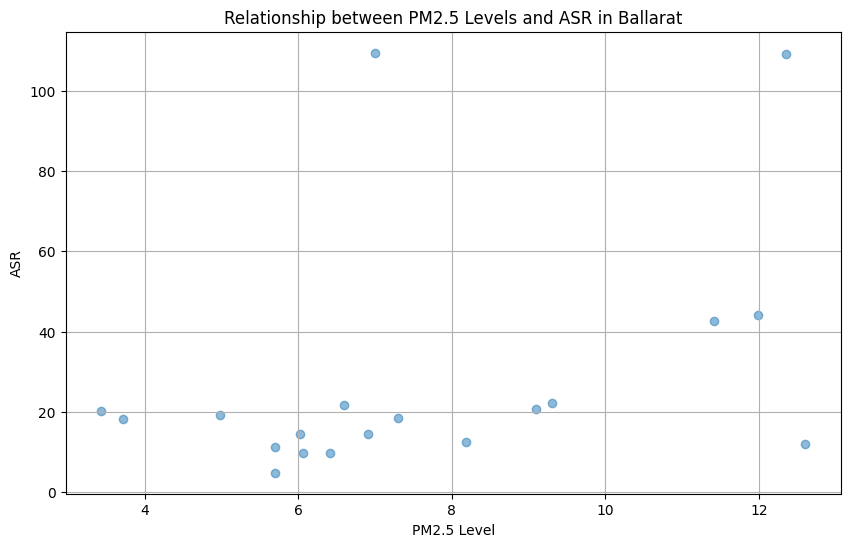

In [10]:
#PM2.5 vs ASR
pm25_data = epa_df[epa_df['healthParameter'] == 'PM2.5']
pm25_data_aligned = pm25_data.head(len(health_df))  # Align data lengths for demonstration

plt.figure(figsize=(10, 6))
plt.scatter(pm25_data_aligned['averageValue'], health_df['ASR'][:len(pm25_data_aligned)], alpha=0.5)
plt.title('Relationship between PM2.5 Levels and ASR in '+ city)
plt.xlabel('PM2.5 Level')
plt.ylabel('ASR')
plt.grid(True)
plt.show()

# city_textbox = widgets.Text(
#     value='Melbourne',
#     description='City:',
#     disabled=False
# )

Text(value='Ballarat', description='City:')

Button(description='Update Plot', style=ButtonStyle())

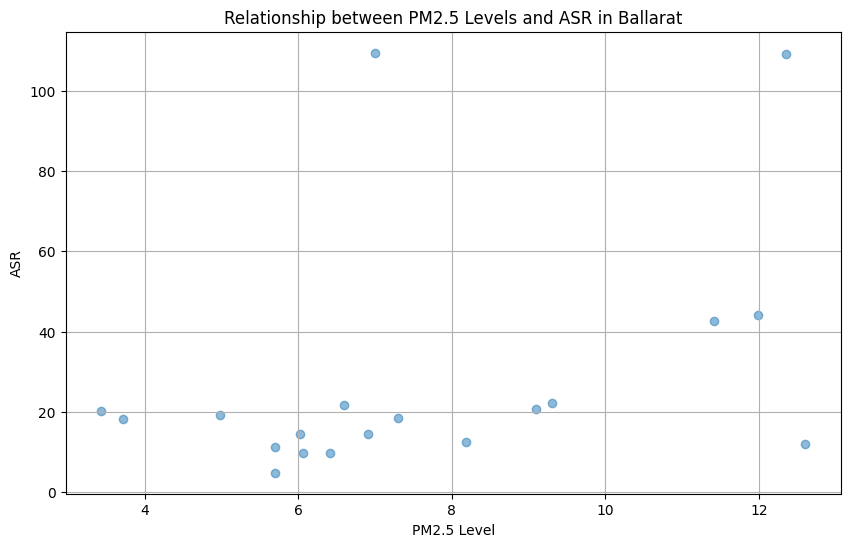

In [23]:
# 定义一个绘图函数
def plot_pm25_asr(city):
    pm25_data = epa_df[epa_df['healthParameter'] == 'PM2.5']
    pm25_data_aligned = pm25_data.head(len(health_df))  # Align data lengths for demonstration

    plt.figure(figsize=(10, 6))
    plt.scatter(pm25_data_aligned['averageValue'], health_df['ASR'][:len(pm25_data_aligned)], alpha=0.5)
    plt.title(f'Relationship between PM2.5 Levels and ASR in {city}')
    plt.xlabel('PM2.5 Level')
    plt.ylabel('ASR')
    plt.grid(True)
    plt.show()

# 创建文本框和按钮，用于输入城市名称
city_textbox = widgets.Text(
    value='Melbourne',
    description='City:',
    disabled=False
)

# 创建一个按钮，当点击时更新图表
button = widgets.Button(description="Update Plot")

# 全局变量存储城市名称
city = ''

# 更新图表的函数
def on_button_clicked(b):
    global city  # 引用全局变量
    city = city_textbox.value  # 更新城市变量
    clear_output(wait=True)  # 清除旧的输出，并等待新的输出
    display(city_textbox, button)  # 重新显示输入框和按钮
    plot_pm25_asr(city)  # 绘制新的图表

# 按钮点击事件
button.on_click(on_button_clicked)

# 显示输入框和按钮
display(city_textbox, button)


In [20]:
city

'Ballarat'

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_and_merge_datasets(bom_df, epa_df):
    """
    Prepares and merges BOM and EPA dataframes based on the hour of the day.

    Parameters:
    - bom_df: DataFrame containing BOM data with a 'local_date_time' column.
    - epa_df: DataFrame containing EPA data with an 'hour' column.

    Returns:
    - Merged DataFrame on hourly precision.
    """
    # Convert 'local_date_time' from BOM to datetime and extract the hour for merging
    bom_df['hour'] = pd.to_datetime(bom_df['local_date_time'], format='%Y%m%d%H%M%S').dt.hour

    # Convert 'hour' in EPA to datetime, and extract the hour
    epa_df['hour'] = pd.to_datetime(epa_df['hour'], format='%H:%M:%S').dt.hour

    # Merge on the 'hour' column
    merged_df = pd.merge(bom_df, epa_df, on='hour', suffixes=('_bom', '_epa'))
    
    return merged_df

def create_heatmap(data, weather_cols, air_quality_cols):
    """
    Creates a heatmap showing the correlation between specified weather conditions and air quality indices.

    Parameters:
    - data: DataFrame with merged weather and air quality data.
    - weather_cols: List of column names related to weather conditions.
    - air_quality_cols: List of column names related to air quality indices.
    """
    # Focus on relevant columns only
    relevant_data = data[weather_cols + air_quality_cols]
    
    # Compute the correlation matrix
    corr_matrix = relevant_data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation between Weather Conditions and Air Quality Indices')
    plt.show()

# Example usage:
# Assume 'bom_df' and 'epa_df' are already loaded DataFrames with the appropriate columns.
# merged_df = prepare_and_merge_datasets(bom_df, epa_df)
# create_heatmap(merged_df, ['apparent_temperature', 'delta_temperature'], ['averageValue'])


In [31]:
merged_df = prepare_and_merge_datasets(bom_df, epa_df)
print(merged_df)

                   site_name local_date_time coordinates_bom  \
0   Melbourne (Olympic Park)  20240503153000  [-37.8, 145.0]   
1          Melbourne Airport  20240503153000  [-37.7, 144.8]   
2   Melbourne (Olympic Park)  20240503160000  [-37.8, 145.0]   
3          Melbourne Airport  20240503160000  [-37.7, 144.8]   
4   Melbourne (Olympic Park)  20240503170000  [-37.8, 145.0]   
5          Melbourne Airport  20240503170000  [-37.7, 144.8]   
6   Melbourne (Olympic Park)  20240503180000  [-37.8, 145.0]   
7          Melbourne Airport  20240503180000  [-37.7, 144.8]   
8   Melbourne (Olympic Park)  20240503190000  [-37.8, 145.0]   
9          Melbourne Airport  20240503190000  [-37.7, 144.8]   
10  Melbourne (Olympic Park)  20240503200000  [-37.8, 145.0]   
11         Melbourne Airport  20240503200000  [-37.7, 144.8]   
12  Melbourne (Olympic Park)  20240503210000  [-37.8, 145.0]   
13         Melbourne Airport  20240503210000  [-37.7, 144.8]   
14  Melbourne (Olympic Park)  2024050322

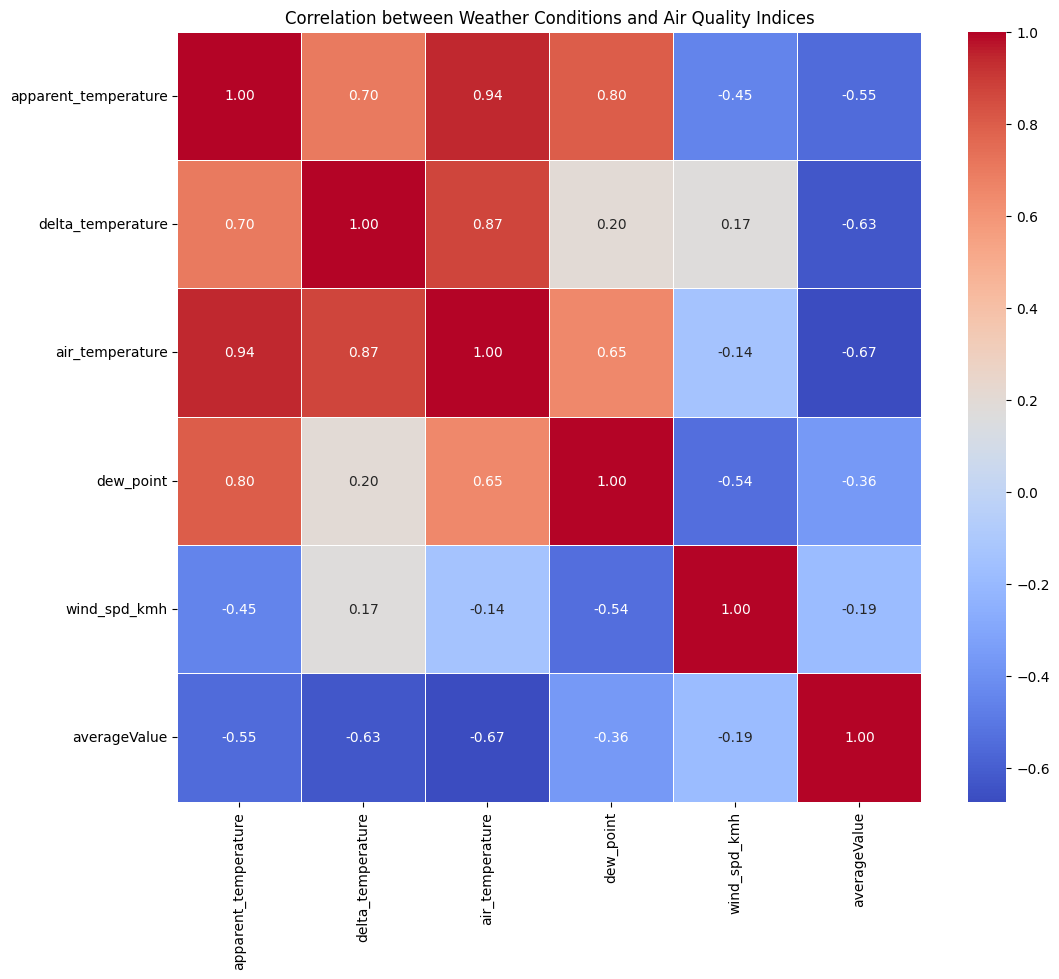

In [37]:
# 定义相关天气条件和空气质量指标的列
weather_columns = ['apparent_temperature', 'delta_temperature', 'air_temperature', 'dew_point', 'wind_spd_kmh']
air_quality_columns = ['averageValue']

# 调用函数生成热力图
create_heatmap(merged_df, weather_columns, air_quality_columns)
